## Libraries

In [1]:
# This is our custom implementation of the KNN algorithm, the algorithm is in the path knn/knn_implementation.py
from gd_implementation import LinearRegressionGD
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score
    )
import time

import numpy as np
import pandas as pd

## Usage example

In [2]:
np.random.seed(0)
X_train = 2 * np.random.rand(80, 10)
X_test = 2 * np.random.rand(20, 10)

bias = 2
weights = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

y_train = bias + np.dot(X_train, weights) + np.random.randn(80)
y_test = bias + np.dot(X_test, weights) + np.random.randn(20)

model = LinearRegressionGD(learning_rate=0.001, epochs=1000)
model.fit(X_train, y_train)

print("Weights:", model.weights)
print("Bias:", model.bias)
print("Actual Test targets:", y_test)
print("Predictions:", model.predict(X_test))

Weights: [2.46558591 3.12615411 2.95804893 3.30401286 3.94875112 4.03950524
 4.76851278 5.81611628 6.05176797 7.13393274]
Bias: 4.0319345485706375
Actual Test targets: [66.09728268 41.3754647  44.63672815 49.51621888 47.49726723 38.56707707
 49.30287676 50.11776257 55.74723549 50.80082284 29.46541632 45.76910553
 48.0721033  41.67232871 54.03397453 54.14698979 45.15096965 45.20635833
 61.85588391 47.62367706]
Predictions: [60.30305785 42.74220441 42.58151507 49.5921947  47.71223227 44.77774487
 52.85473166 50.84414002 57.0453316  50.95731569 35.00259724 47.80513352
 50.21227143 41.97361813 48.05054025 51.96216793 44.28020364 47.74298283
 64.47817106 45.6817608 ]


## Dataset 1 - Bike Sharing

### Data preprocessing


In [3]:
# Load the bike sharing dataset
from sklearn.preprocessing import OneHotEncoder

bike_sharing = pd.read_csv('../datasets/original/bike_sharing.csv')

bike_sharing = bike_sharing.drop(['casual', 'registered'], axis=1)

encoderOHE = OneHotEncoder()

# one-hot encoding for the categorical variables season, weathersit
season_encoded = encoderOHE.fit_transform(bike_sharing[['season']]).toarray()
weathersit_encoded = encoderOHE.fit_transform(bike_sharing[['weathersit']]).toarray()

# Add the encoded columns to the dataset
bike_sharing['spring'] = season_encoded[:, 0]
bike_sharing['summer'] = season_encoded[:, 1]
bike_sharing['fall'] = season_encoded[:, 2]
bike_sharing['winter'] = season_encoded[:, 3]

bike_sharing['weather_1'] = weathersit_encoded[:, 0]
bike_sharing['weather_2'] = weathersit_encoded[:, 1]
bike_sharing['weather_3'] = weathersit_encoded[:, 2]
bike_sharing['weather_4'] = weathersit_encoded[:, 3]

# Drop the original columns
bike_sharing = bike_sharing.drop(['season', 'weathersit'], axis=1)

# Drop columns that are not needed
bike_sharing = bike_sharing.drop(['instant', 'dteday'], axis=1)

### Splitting the data and normalizing it

In [4]:
# Split the dataset into features and target variable
X = bike_sharing.drop('cnt', axis=1)
y = bike_sharing['cnt']

# Split the dataset into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Normalize the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# Note: In a previous test I normalized the columns 'casual', 'registered' and the results were way worse. With mae around 30 and mse around 1700
# With the current configuration we are getting good results, mae around ~1 and mse around ~5-30
variables_to_normalize = ['mnth', 'hr', 'weekday']

X_train[variables_to_normalize] = scaler.fit_transform(X_train[variables_to_normalize]) 
X_test[variables_to_normalize] = scaler.transform(X_test[variables_to_normalize])

X_train
 

,yr,mnth,hr,holiday,weekday,workingday,temp,atemp,hum,windspeed,spring,summer,fall,winter,weather_1,weather_2,weather_3,weather_4
1945,0,0.181818,0.869565,0,1.000000,0,0.28,0.2727,0.45,0.2537,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
13426,1,0.545455,0.652174,0,0.500000,1,0.92,0.8485,0.35,0.3582,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
12898,1,0.454545,0.652174,0,0.333333,1,0.72,0.6515,0.28,0.4627,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2570,0,0.272727,0.000000,0,0.833333,1,0.36,0.3485,0.62,0.1940,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
10764,1,0.181818,0.652174,0,0.666667,1,0.52,0.5000,0.39,0.3582,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,1,0.272727,0.391304,0,0.833333,1,0.46,0.4545,0.88,0.0896,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
11964,1,0.363636,0.739130,0,0.833333,1,0.66,0.6212,0.34,0.1343,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
5390,0,0.636364,0.521739,0,0.500000,1,0.80,0.7273,0.43,0.2836,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
860,0,0.090909,0.304348,0,0.333333,1,0.24,0.1970,0.65,0.4179,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


## Testing multiple configurations

In [5]:
def predict_gd_all_configurations(X_train, y_train, X_test, y_test):
    results = []
    for lr in [0.1, 0.001, 0.0001]:
        for epochs in [1, 100, 1000, 5000]:
            model = LinearRegressionGD(learning_rate=lr, epochs=epochs)
            model.fit(X_train, y_train)
            prediction = model.predict(X_test)
            mae = mean_absolute_error(y_test, prediction)
            mse = mean_squared_error(y_test, prediction)
            r2 = r2_score(y_test, prediction)
            results.append({
                'lr': lr,
                'epochs': epochs,
                'mae': mae,
                'mse': mse,
                'r2': r2
            })
    return results

In [6]:
results = predict_gd_all_configurations(X_train, y_train, X_test, y_test)

results

[{'lr': 0.1,
  'epochs': 1,
  'mae': 127.94562763702775,
  'mse': 29448.058813291525,
  'r2': 0.0842784536185941},
 {'lr': 0.1,
  'epochs': 100,
  'mae': 106.61720154411898,
  'mse': 20220.54967076993,
  'r2': 0.3712185536371584},
 {'lr': 0.1,
  'epochs': 1000,
  'mae': 104.44180087550758,
  'mse': 19427.47481246066,
  'r2': 0.39588013626478447},
 {'lr': 0.1,
  'epochs': 5000,
  'mae': 104.44361957948878,
  'mse': 19423.501065601555,
  'r2': 0.39600370453262235},
 {'lr': 0.001,
  'epochs': 1,
  'mae': 185.06601426970226,
  'mse': 66366.94543700104,
  'r2': -1.0637571491384858},
 {'lr': 0.001,
  'epochs': 100,
  'mae': 129.7990178410316,
  'mse': 35297.267672075985,
  'r2': -0.09760948049733331},
 {'lr': 0.001,
  'epochs': 1000,
  'mae': 124.38033361245414,
  'mse': 25678.426633314954,
  'r2': 0.20149953875101057},
 {'lr': 0.001,
  'epochs': 5000,
  'mae': 110.35105412523114,
  'mse': 21372.964308849285,
  'r2': 0.33538288374986913},
 {'lr': 0.0001,
  'epochs': 1,
  'mae': 186.548190601

In [7]:
model = LinearRegressionGD(learning_rate=0.01, epochs=5000)

model.fit(X_train, y_train)

runtime_start = time.process_time()
prediction = model.predict(X_test)
runtime_end = time.process_time()
mae = mean_absolute_error(y_test, prediction)
mse = mean_squared_error(y_test, prediction)
r2 = r2_score(y_test, prediction)


runtime = runtime_end - runtime_start

mae, mse, r2, runtime

(104.4720681538381, 19459.76218525292, 0.3948761229568316, 0.00995523200003845)

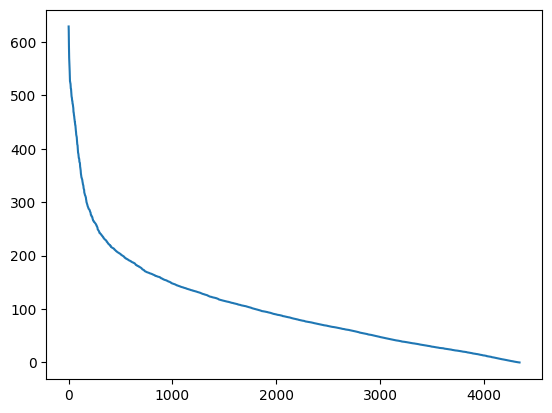

In [8]:
# Plot difference between real and predicted values
from matplotlib import pyplot as plt

# List of values y_test - prediction and sort it descending
sorted_values = sorted(abs(y_test.values - prediction), reverse=True)


plt.plot(sorted_values)
plt.show()


## Dataset 2 - Combined Cycle Power Plant 

In [9]:
# Load the combined cycle power plant dataset
ccpp = pd.read_csv('../datasets/original/ccpp.csv')

# Split the dataset into features and target variable
ccpp_X = ccpp.drop('PE', axis=1)
ccpp_y = ccpp['PE']

# Split the dataset into training and testing data
ccpp_X_train, ccpp_X_test, ccpp_y_train, ccpp_y_test = train_test_split(ccpp_X, ccpp_y, test_size=0.25, random_state=42)

# Normalize the data
scaler = MinMaxScaler()

variables_to_normalize = ['AT', 'V', 'AP', 'RH']

# Fit transform varirables AT, V, AP, RH
ccpp_X_train[variables_to_normalize] = scaler.fit_transform(ccpp_X_train[variables_to_normalize]) 
ccpp_X_test[variables_to_normalize] = scaler.transform(ccpp_X_test[variables_to_normalize])

ccpp_X_train

,AT,V,AP,RH
2058,0.464589,0.289493,0.005444,0.492425
8042,0.839377,0.712879,0.523385,0.316262
7612,0.314448,0.297337,0.506805,0.616168
1166,0.386969,0.385261,0.366246,0.878268
3597,0.838244,0.751186,0.263796,0.431291
...,...,...,...,...
5734,0.692351,0.650493,0.459787,0.612146
5191,0.775071,0.719263,0.582529,0.475801
5390,0.458640,0.334549,0.557040,0.478885
860,0.705949,0.793141,0.441970,0.553291


In [10]:
ccpp_results = predict_gd_all_configurations(ccpp_X_train, ccpp_y_train, ccpp_X_test, ccpp_y_test)

ccpp_results

[{'lr': 0.1,
  'epochs': 1,
  'mae': 255.2630449624813,
  'mse': 66067.46544122811,
  'r2': -228.3218351700864},
 {'lr': 0.1,
  'epochs': 100,
  'mae': 23.204500792305723,
  'mse': 845.668319418621,
  'r2': -1.9353360184037367},
 {'lr': 0.1,
  'epochs': 1000,
  'mae': 7.7101243621073445,
  'mse': 95.40041841254629,
  'r2': 0.668862746886805},
 {'lr': 0.1,
  'epochs': 5000,
  'mae': 3.6089091542111764,
  'mse': 20.206329025777432,
  'r2': 0.9298633234483026},
 {'lr': 0.001,
  'epochs': 1,
  'mae': 452.33597388607967,
  'mse': 204899.55797805474,
  'r2': -710.2115221502826},
 {'lr': 0.001,
  'epochs': 100,
  'mae': 293.2280975858646,
  'mse': 86726.29361036833,
  'r2': -300.02914763578235},
 {'lr': 0.001,
  'epochs': 1000,
  'mae': 38.4232196580392,
  'mse': 2137.2799361402863,
  'r2': -6.4185524441511665},
 {'lr': 0.001,
  'epochs': 5000,
  'mae': 27.948806118689074,
  'mse': 1203.5362226113218,
  'r2': -3.1775045163253886},
 {'lr': 0.0001,
  'epochs': 1,
  'mae': 454.1275459672032,
  '

## Dataset 3 - Online News Popularity

In [11]:
# Load the bike sharing dataset
online_news = pd.read_csv('../datasets/original/OnlineNewsPopularity.csv')

# Drop url since it functions as an ID
online_news = online_news.drop(['url'], axis=1)

# Split the dataset into features and target variable
on_X = online_news.drop('shares', axis=1)
on_y = online_news['shares']

# Split the dataset into training and testing data
on_X_train, on_X_test, on_y_train, on_y_test = train_test_split(on_X, on_y, test_size=0.25, random_state=42)

# Normalize the data
scaler = MinMaxScaler()


# Fit transform all variables
on_X_train_scaled = scaler.fit_transform(on_X_train) 
on_X_train = pd.DataFrame(on_X_train_scaled, columns=on_X_train.columns)
on_X_test_scaled = scaler.transform(on_X_test)
on_X_test =  pd.DataFrame(on_X_test_scaled, columns=on_X_test.columns)


least_important_features = [
'global_rate_negative_words',
'rate_positive_words',
'rate_negative_words',
'is_weekend',
'min_positive_polarity',
'max_positive_polarity',
'global_sentiment_polarity',
'avg_negative_polarity',
'min_negative_polarity',
'abs_title_subjectivity',
'LDA_00',
'timedelta',
'weekday_is_sunday',
'kw_min_min',
'n_non_stop_words',
'average_token_length',
'num_keywords',
'data_channel_is_lifestyle',
'data_channel_is_entertainment',
'data_channel_is_bus',
'data_channel_is_socmed',
'data_channel_is_tech',
'kw_max_min',
'weekday_is_saturday',
'kw_min_max',
'kw_max_max',
'n_tokens_title',
'weekday_is_monday',
'weekday_is_tuesday',
'weekday_is_wednesday',
'weekday_is_sunday',
'weekday_is_thursday',
'weekday_is_friday',
'abs_title_sentiment_polarity'
]

on_X_train = on_X_train.drop(least_important_features, axis=1)
on_X_test = on_X_test.drop(least_important_features, axis=1)

In [12]:
on_results = predict_gd_all_configurations(on_X_train, on_y_train, on_X_test, on_y_test)

on_results

[{'lr': 0.1,
  'epochs': 1,
  'mae': 2525.454925605184,
  'mse': 118058601.66970383,
  'r2': -0.012758618553410095},
 {'lr': 0.1,
  'epochs': 100,
  'mae': 3103.042661229265,
  'mse': 115343590.09968416,
  'r2': 0.010531945015201494},
 {'lr': 0.1,
  'epochs': 1000,
  'mae': 3084.5440773390364,
  'mse': 114672509.39521483,
  'r2': 0.016288770503425365},
 {'lr': 0.1,
  'epochs': 5000,
  'mae': 3060.3075691994045,
  'mse': 114009885.58550934,
  'r2': 0.021973049028216063},
 {'lr': 0.001,
  'epochs': 1,
  'mae': 3334.249952968747,
  'mse': 127686343.692642,
  'r2': -0.09534962482518505},
 {'lr': 0.001,
  'epochs': 100,
  'mae': 2418.92509084935,
  'mse': 119662425.53311656,
  'r2': -0.026516925168434957},
 {'lr': 0.001,
  'epochs': 1000,
  'mae': 3132.743863035748,
  'mse': 115860366.05926044,
  'r2': 0.006098813506611123},
 {'lr': 0.001,
  'epochs': 5000,
  'mae': 3107.24339482132,
  'mse': 115429922.24815418,
  'r2': 0.009791349868514487},
 {'lr': 0.0001,
  'epochs': 1,
  'mae': 3352.794